In [86]:
import os
import math
import h5py
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches



# Previos

Descargar los últimos 4 archivos del siguiente [portal](https://portal.nersc.gov/project/cusp/ssl_galaxy_surveys/strong_lens_data/) y colocarlos en la misma ruta que este archivo.


![galaxi portal](Resultados/galaxy_surveys.png)

In [22]:
"""
Transformation from raw image data (nanomaggies) to the rgb values displayed
at the legacy viewer https://www.legacysurvey.org/viewer

Code copied from
https://github.com/legacysurvey/imagine/blob/master/map/views.py
"""

def sdss_rgb(imgs, bands, scales=None,
             m = 0.02):
    import numpy as np
    rgbscales = {'u': (2,1.5), #1.0,
                 'g': (2,2.5),
                 'r': (1,1.5),
                 'i': (0,1.0),
                 'z': (0,0.4), #0.3
                 }
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)
        
    # b,g,r = [rimg * rgbscales[b] for rimg,b in zip(imgs, bands)]
    # r = np.maximum(0, r + m)
    # g = np.maximum(0, g + m)
    # b = np.maximum(0, b + m)
    # I = (r+g+b)/3.
    Q = 20
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-6
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I

    # R = fI * r / I
    # G = fI * g / I
    # B = fI * b / I
    # # maxrgb = reduce(np.maximum, [R,G,B])
    # # J = (maxrgb > 1.)
    # # R[J] = R[J]/maxrgb[J]
    # # G[J] = G[J]/maxrgb[J]
    # # B[J] = B[J]/maxrgb[J]
    # rgb = np.dstack((R,G,B))
    rgb = np.clip(rgb, 0, 1)
    return rgb

def dr2_rgb(rimgs, bands, **ignored):
    return sdss_rgb(rimgs, bands, scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

In [28]:
def plot_skymap(ra, dec, carr=None, field_str='', title=None, cmap='viridis', ptsize=20, pt_alpha=0.8, ra_shift=80., dra_lab=20):
    """Scatter plot of (ra, dec, color) in aitoff projection
    
    Parameters                                                                                  
    ----------                                                                                  
    ra : array                                                                        
        right ascension in deg                                                               
    dec : array                                                                        
        declination in deg
    carr : array                                                                        
        array to color data points by
    field_str : str
        colorbar label, if carr provided
    """
    ra_shift_rad = np.deg2rad(ra_shift)
    cm = plt.get_cmap(cmap)

    plt.figure(figsize=(16,8))
    plt.subplot(111, projection='aitoff')
    plt.grid(True)
    
    # default rotates to same frame as figures
    ra = np.deg2rad(ra)
    ra[ra>np.pi] -= 2*np.pi
    ra += ra_shift_rad
    ra = (ra+np.pi)%(2*np.pi)-np.pi 
    ra *= -1 # flip so ra increases to left (silly astronomers)

    dec = np.deg2rad(dec)
    
    plt.scatter(ra, dec, c=carr, label=field_str, s=ptsize, cmap=cm, alpha=pt_alpha)

    # set figure aesthetics
    plt.plot(np.linspace(-np.pi, np.pi, 360), np.deg2rad(np.full((360,), 32.375)), c='grey', lw=1, ls=':') 

    if carr is not None:
        cb = plt.colorbar(label=field_str, fraction=0.02, pad=0.02)
        
    xticks = np.arange(-180+dra_lab, 180+dra_lab, dra_lab)
    xtick_labels = np.arange(0, 360, dra_lab).astype(int)[::-1]
    xtick_labels = np.roll(xtick_labels, int(xtick_labels.shape[0]//2-ra_shift//dra_lab )) 
    xtick_labels = ['{:d}$^o$'.format(i) for i in xtick_labels]
    plt.xticks(ticks=np.radians(xticks), labels=xtick_labels, rotation=30)
    plt.grid(True, linestyle=':')
    
    plt.title(title)
    plt.show()


def show_galaxies(images, ra, dec, display_radec=True,
                  title=None, is_previous_lens=None, is_new_lens=None, label_lenses=False,
                  nx=8, npix_show=96, nplt=None, savepath=None,
                  panel_size=[3,3], lw_rect=3, lw_border=1, ls_border='-', fontsize=12, colors=['C0', 'red']):
    """Plot images in an nx by len(images)//nx array
    
    Parameters
    ----------
    images : array
        an (N_img, npix_x, npix_y) array
    is_previous_lens: boolean array
        (N_img) array denoting whether the galaxy is a lens previously identified in literature
    is_new_lens: boolean array
        (N_img) array denoting whether the galaxy is a lens identified in out work
    label_lens: boolean
        whether or not to use lens labels
    nx: int
        number of images to display in each row
    nplt : int
        total number to plot if < N_img desired
    """
    
    nimg = images.shape[0]
    npix = images.shape[-1]
    
    ipix_start = npix//2 - npix_show//2
    ipix_end = npix//2 + npix_show//2

    ny = math.ceil(nimg/nx)
    if nplt is not None:
        ny = math.ceil(nplt/nx)
    nplt = nx*ny

    # instead of subplots plot as one large image - this is much faster
    image_full = np.ones((ny*npix_show, nx*npix_show, 3), dtype=np.float32)

    fig, ax = plt.subplots(1, 1, figsize=(nx*panel_size[0], ny*panel_size[1]))
    plt.subplots_adjust(wspace=0.00, hspace=0.00)

  
    fi = 0
    ntot = 0
    for i in range(ny):
        for j in range(nx):
            im = images[fi]

            image_full[i*npix_show+lw_border:(i+1)*npix_show-lw_border, 
                       j*npix_show+lw_border:(j+1)*npix_show-lw_border] = dr2_rgb(images[fi, :, 
                                                                                         ipix_start+lw_border:ipix_end-lw_border, 
                                                                                         ipix_start+lw_border:ipix_end-lw_border], 
                                                                                  ['g','r','z'])[::-1]

            fi+=1

            if fi >= nimg:
                break
        if fi >= nimg:
            break

    ax.imshow(image_full, interpolation='none')
    ax.axis('off')

    if label_lenses or display_radec:
        # color previous lenses
        fi = 0
        for i in range(ny):
            for j in range(nx):
                if label_lenses:
                    is_lens = is_previous_lens[fi] | is_new_lens[fi]

                    if is_lens:
                        ilp = is_previous_lens[fi]
                        if ilp:
                            ci = colors[0]
                        else:
                            ci = colors[1]


                        rect = patches.Rectangle((lw_border+j*npix_show,  lw_border+i*npix_show),
                                                 npix_show-lw_border*2-1, npix_show-lw_border*2-1, 
                                                 linewidth=lw_rect, ls=ls_border, edgecolor=ci, facecolor='none')#, alpha=0.2)#, 'none')
                        ax.add_patch(rect)

                if display_radec:
                    txt = '{:.4f} {:.4f}'.format(ra[fi], dec[fi])
                    ax.text(5+j*npix_show, (i-1)*npix_show + npix_show+5, txt, color='w', ha='left', va='top', fontsize=fontsize)
                
                fi+=1

                if fi >= nimg:
                    break
            if fi >= nimg:
                break

    if label_lenses:
        lw_leg = 2

        if ny > 1:
            ax.plot(0, 0, lw=lw_leg, color=colors[0], label="Previous Lens")
            ax.plot(0, 0, lw=lw_leg, color=colors[1], label="New Lens")
     
            ax.legend(ncol=2, bbox_to_anchor=(0.5, 1.01), loc='center', frameon=False)

    if title is not None:
        ax.set_title(title)


def list_files(startpath):
    """Print directory structure and files within

    Taken from https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
    """
    print(f'{startpath} structure and files:')

    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
 

In [88]:
class Requester:
    def __init__(self, name="DESI Legacy Imaging Surveys"):
        self.url = 'https://www.legacysurvey.org/viewer/'
        self.name = name

    def __str__(self):
        return f'Requester for {self.name}'

    def urlGenerator(self, **kwargs):
        if not(kwargs['ra'] and kwargs['dec']):
            raise ValueError("Las coordenadas deben ser incluidas")
        
        toolName = 'jpeg-cutout'

        ra = kwargs['ra']
        dec = kwargs['dec']
        size = kwargs['size'] if kwargs['size'] else '128'
        bands = kwargs['bands'] if kwargs['bands'] else 'gr'
        layer = kwargs['layer'] if kwargs['layer'] else 'ls-dr9'
        pixscale = kwargs['pixscale'] if kwargs['pixscale'] else '0.26'

        return f'{self.url}{toolName}?ra={ra}&dec={dec}&size={size}&layer={layer}&pixscale={pixscale}&bands={bands}'
        

    def get(self, parameters:dict):
        return requests.get(self.urlGenerator(**parameters)).content


    def post(self):
        return
    def delete(self):
        return
    def update(self):
        return

In [2]:
fs = 16
plt.rcParams.update(
    {
        'font.size': fs, 
        'axes.labelsize': fs, 
        'legend.fontsize': fs,
        'xtick.labelsize': fs,
        'ytick.labelsize': fs,
        'axes.linewidth': 1.0
    }
)

data_dir = 'Resultados/'
data_host_url = 'https://portal.nersc.gov/project/cusp/ssl_galaxy_surveys/strong_lens_data/'

# Cargando los nuevos datos propuestos del archivo tsv

In [16]:
fileName = 'new_lenses.tsv'

lenses = pd.read_csv(fileName, sep='\t')
lenses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           1192 non-null   float64
 1   dec          1192 non-null   float64
 2   source_type  1192 non-null   object 
 3   ebv          1192 non-null   float64
 4   z_spec       1192 non-null   float64
 5   z_phot_mean  1192 non-null   float64
 6   z_phot_l68   1192 non-null   float64
 7   z_phot_u68   1192 non-null   float64
 8   mag_g        1192 non-null   float64
 9   mag_r        1192 non-null   float64
 10  mag_z        1192 non-null   float64
 11  nobs_g       1192 non-null   int64  
 12  nobs_r       1192 non-null   int64  
 13  nobs_z       1192 non-null   int64  
 14  inds         1192 non-null   int64  
 15  region       1192 non-null   object 
 16  grade        1192 non-null   object 
dtypes: float64(10), int64(4), object(3)
memory usage: 158.4+ KB


In [14]:
regions = np.unique(lenses['region'])
grades = np.unique(lenses['grade'])

for region in regions:
    for grade in grades:
        nlens = np.sum( (lenses['region'] == region) & (lenses['grade'] == grade))
        print(f'Region = {region}, Grade={grade}, Nlens={nlens}')

nlens_total = len(lenses['grade'])
print(f'\nTotal = {nlens_total}')

Region = north, Grade=A, Nlens=41
Region = north, Grade=B, Nlens=74
Region = south, Grade=A, Nlens=363
Region = south, Grade=B, Nlens=714

Total = 1192


In [17]:
# Set up plot configuration 
files_in = ['training_lenses.h5', 'new_lenses.h5']

istart = 0
n_plt = 64
n_cols = 8
npix_show = 96  # Númber of pixeles to show

label_lenses = True
display_radec = True
split_grades = True

In [30]:
file_in = files_in[0]
f5 = h5py.File(file_in, 'r')

f5.keys()

<KeysViewHDF5 ['dec', 'ebv', 'images', 'inds', 'mag_g', 'mag_r', 'mag_z', 'nobs_g', 'nobs_r', 'nobs_z', 'ra', 'representations', 'source_type', 'z_phot_l68', 'z_phot_mean', 'z_phot_u68', 'z_spec']>

In [31]:
images = f5['images']
images

<HDF5 dataset "images": shape (1615, 3, 152, 152), type "<f4">


Keys in training_lenses.h5 are:
-------------------------
dec: (1615,)
ebv: (1615,)
images: (1615, 3, 152, 152)
inds: (1615,)
mag_g: (1615,)
mag_r: (1615,)
mag_z: (1615,)
nobs_g: (1615,)
nobs_r: (1615,)
nobs_z: (1615,)
ra: (1615,)
representations: (1615, 2048)
source_type: (1615,)
z_phot_l68: (1615,)
z_phot_mean: (1615,)
z_phot_u68: (1615,)
z_spec: (1615,)

Keys in new_lenses.h5 are:
-------------------------
dec: (1192,)
ebv: (1192,)
grade: (1192,)
images: (1192, 3, 152, 152)
inds: (1192,)
mag_g: (1192,)
mag_r: (1192,)
mag_z: (1192,)
nobs_g: (1192,)
nobs_r: (1192,)
nobs_z: (1192,)
ra: (1192,)
region: (1192,)
representations: (1192, 2048)
source_type: (1192,)
z_phot_l68: (1192,)
z_phot_mean: (1192,)
z_phot_u68: (1192,)
z_spec: (1192,)


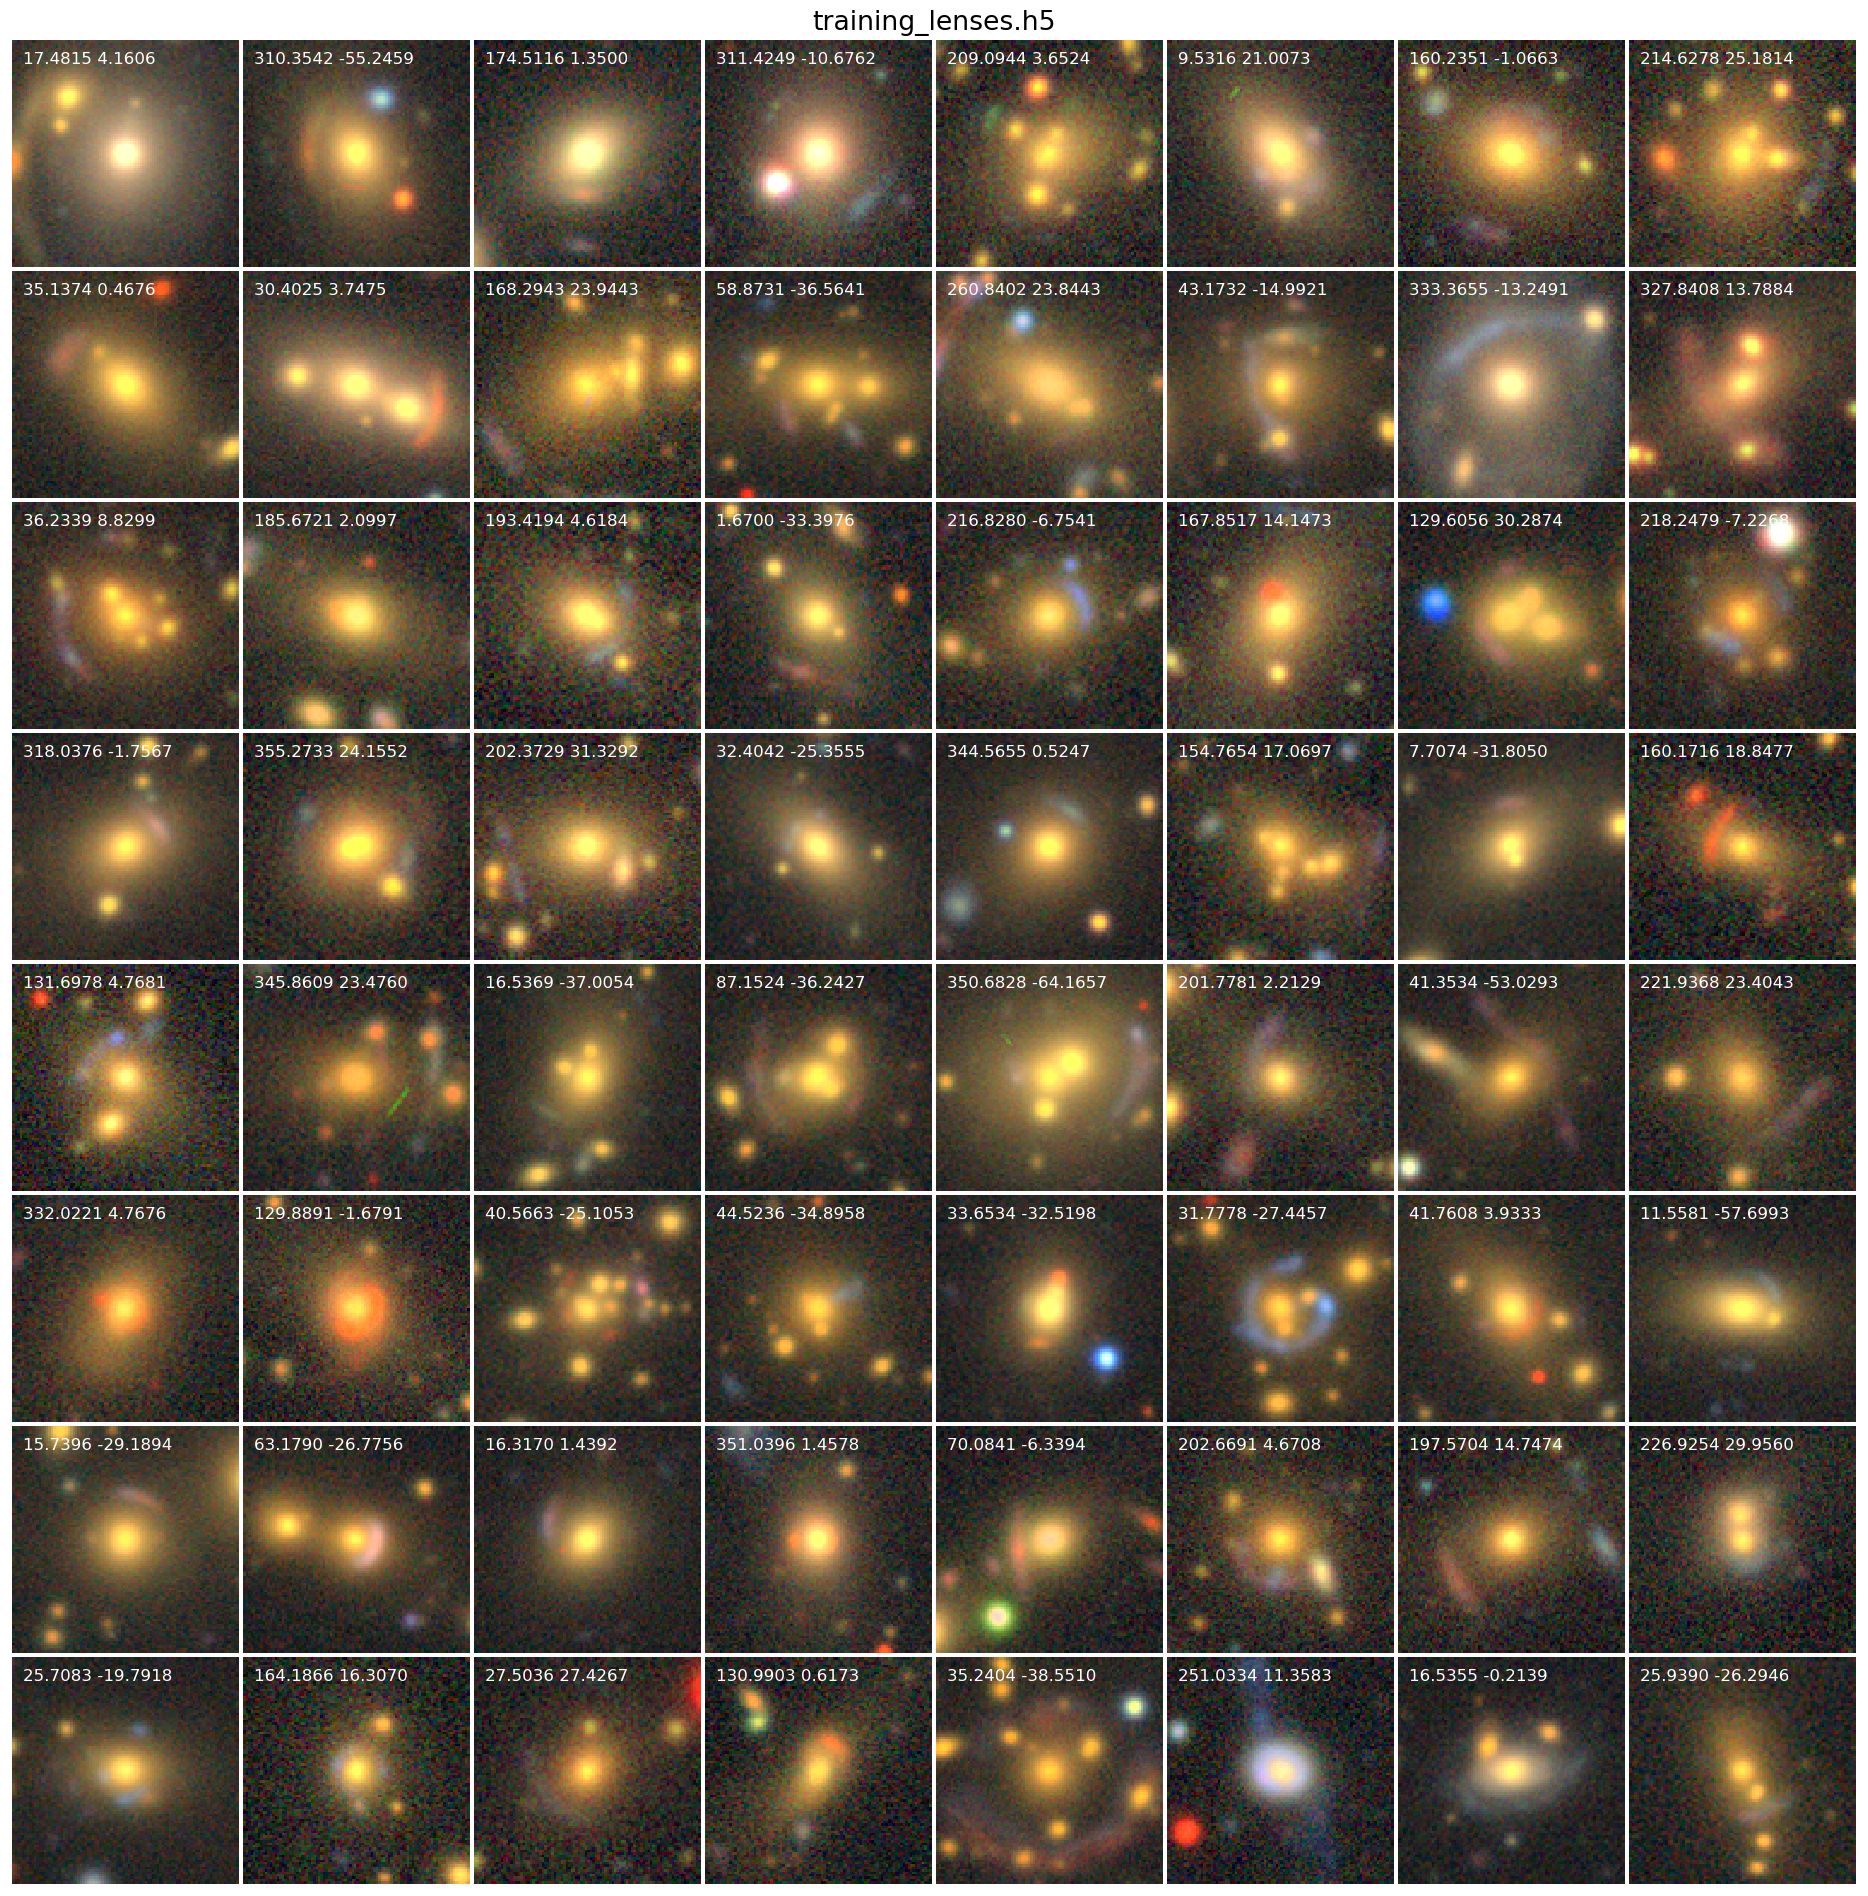

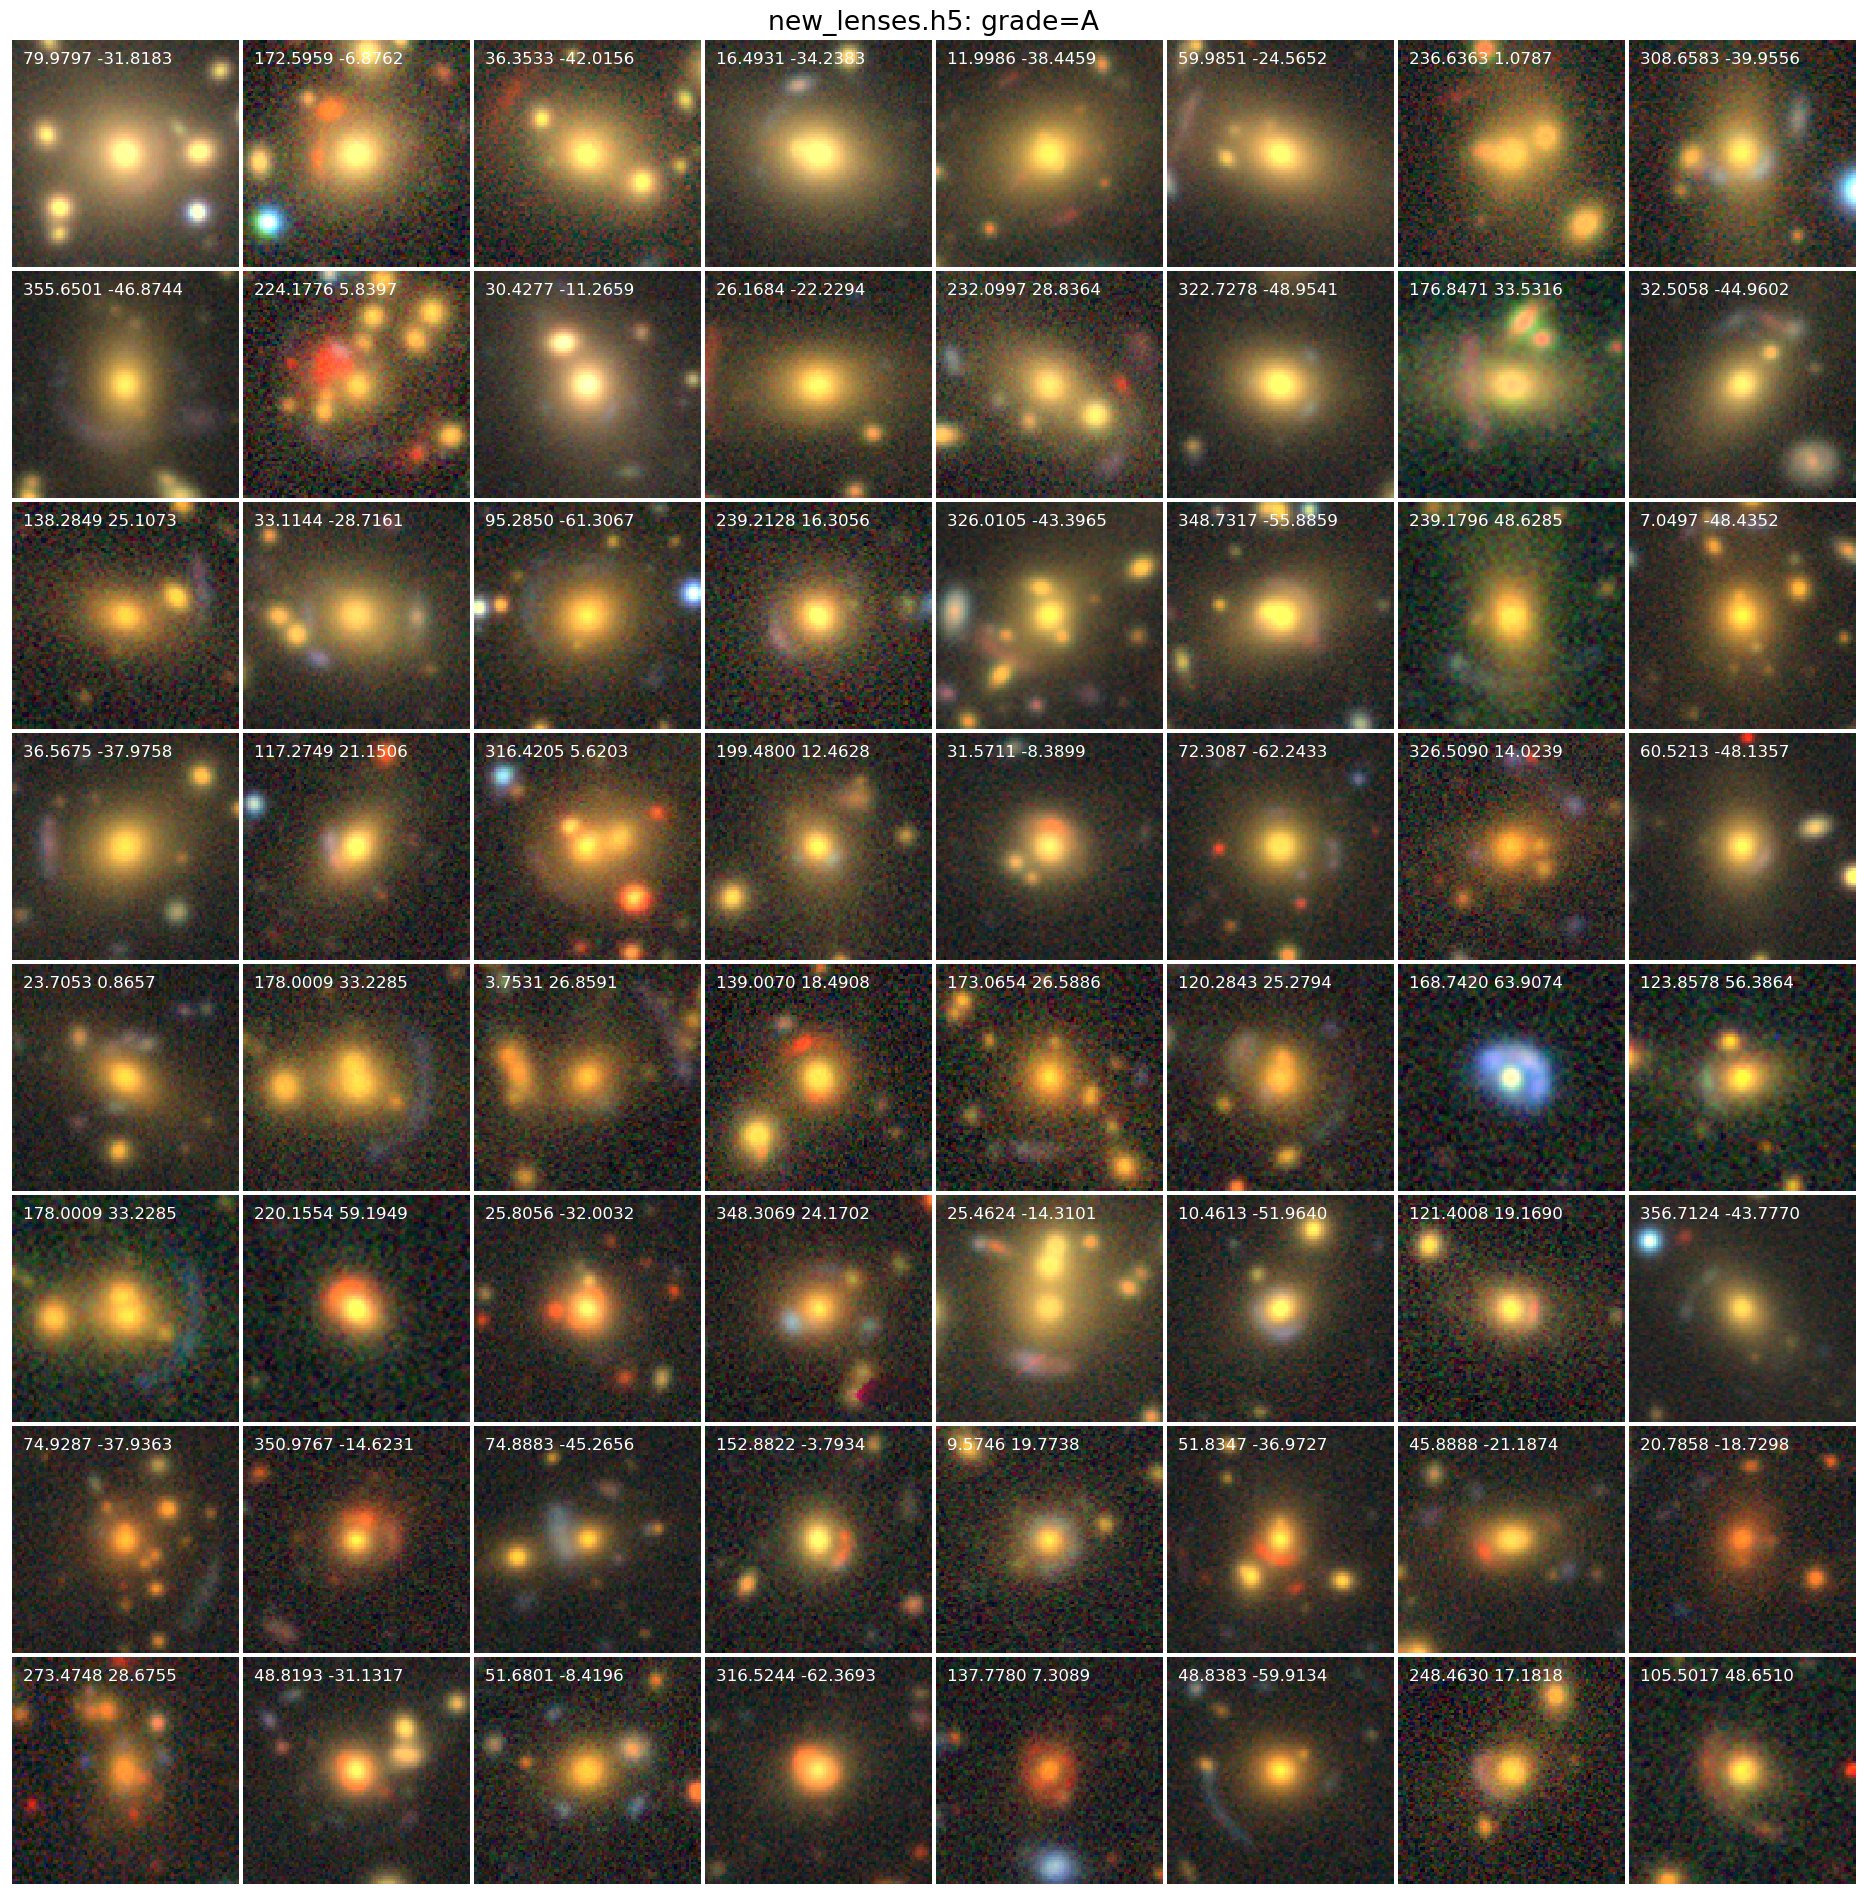

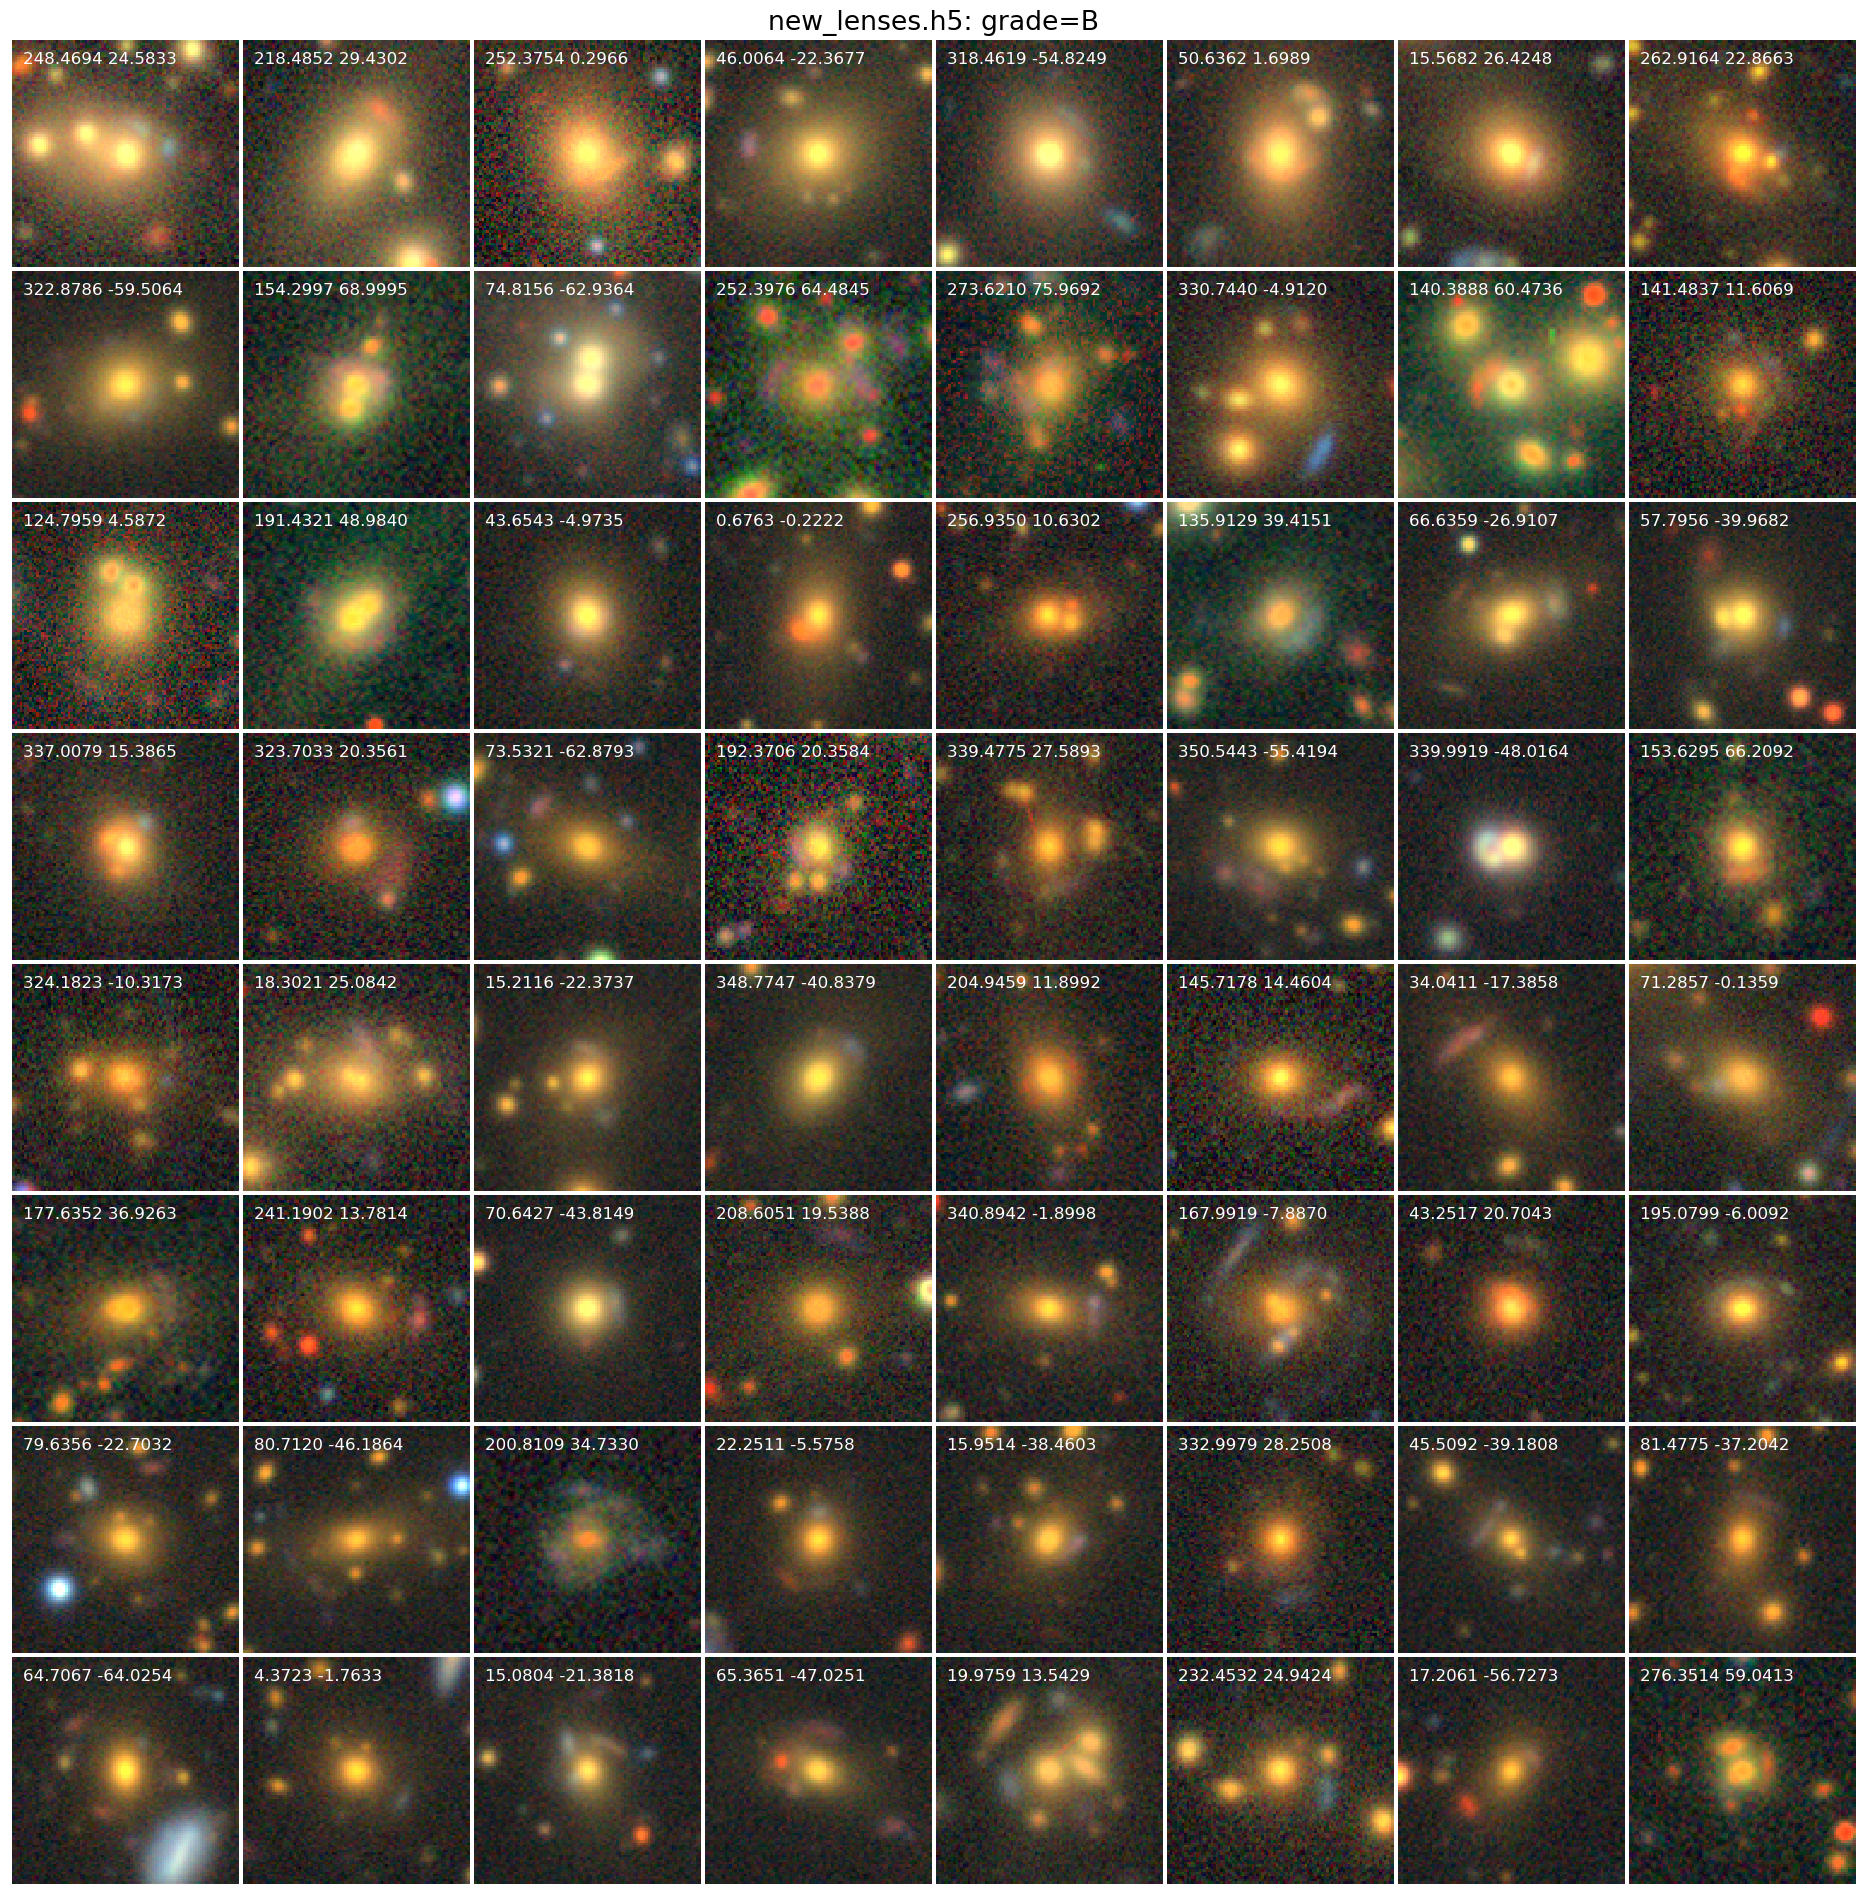

In [29]:
for file_in in files_in:
    with h5py.File(file_in, 'r') as f5:
        print(f'\nKeys in {file_in} are:\n'+'-'*25)
        for k in f5.keys():
            print(f'{k}: {f5[k].shape}')

        if 'grade' in f5.keys() and split_grades:
            grades = f5['grade'][:]
            inds = np.arange(grades.shape[0])

            for grade in np.unique(grades):
                dm = grades == grade
                inds_grade = inds[dm]
                images = f5['images'][inds_grade[istart:istart + n_plt]]
                ra = f5['ra'][inds_grade[istart:istart + n_plt]]
                dec = f5['dec'][inds_grade[istart:istart + n_plt]]

                # plot
                show_galaxies(
                    images, ra, dec, 
                    display_radec=display_radec,
                    title=file_in + f': grade={grade.decode()}',
                    nx=n_cols, nplt=n_plt, npix_show=npix_show
                )
        else:
            images = f5['images'][istart:istart + n_plt]
            ra = f5['ra'][istart:istart + n_plt]
            dec = f5['dec'][istart:istart + n_plt]

            # plot
            show_galaxies(
                images, ra, dec, 
                display_radec=display_radec,
                title=file_in,
                nx=n_cols, nplt=n_plt, npix_show=npix_show
            )

In [70]:
# Getting figures
fileName = 'training_lenses.tsv'

training_lenses = pd.read_csv(fileName, sep='\t')
training_lenses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           1615 non-null   float64
 1   dec          1615 non-null   float64
 2   source_type  1615 non-null   object 
 3   ebv          1615 non-null   float64
 4   z_spec       1615 non-null   float64
 5   z_phot_mean  1615 non-null   float64
 6   z_phot_l68   1615 non-null   float64
 7   z_phot_u68   1615 non-null   float64
 8   mag_g        1615 non-null   float64
 9   mag_r        1615 non-null   float64
 10  mag_z        1615 non-null   float64
 11  nobs_g       1615 non-null   int64  
 12  nobs_r       1615 non-null   int64  
 13  nobs_z       1615 non-null   int64  
 14  inds         1615 non-null   int64  
dtypes: float64(10), int64(4), object(1)
memory usage: 189.4+ KB


In [90]:
def download_folder(start, end, folder, request, df):
    for idx, value in df[start:end].iterrows():
        ra, dec = str(value['ra']), str(value['dec'])
        res = request.get({
            'ra': ra,
            'dec': dec,
            'size': size,
            'layer': layer,
            'pixscale': pixscale,
            'bands': bands
        })

        img = open(
            f'{imgs_dir}{folder}{ra.replace(".", "")}{dec.replace(".", "")}.png',
            'wb'
        )

In [93]:
# Obteniendo imágenes
size = '256' #128'
pixscale = '0.262'

bands = 'grz'
layer = 'ls-dr9'

imgs_dir = './.temp/'

amount = training_lenses.shape[0]
train, test, validation = .7, .2, .1

desiRequester = Requester()


# training
start = 0
end = int(amount*train)
folderName = 'train/'
download_folder(start, end, folderName, desiRequester, training_lenses)


# test
start = int(amount*train)
end += int(amount*test)
folderName = 'test/'
download_folder(start, end, folderName, desiRequester, training_lenses)

# validation
start = int(amount*test)
end += int(amount*validation)
folderName = 'validation/'
download_folder(start, end, folderName, desiRequester, training_lenses)

